# Predictive Model for Occurence Estimation

*Referneces*  
* [Hong Kong Map](https://data.gov.hk/en-data/dataset/hk-landsd-openmap-b50k-topographic-map-of-hong-kong)
* [Hong Kong Districts](https://opendata.esrichina.hk/datasets/esrihk::hong-kong-district-boundary/about)  
* [Occurence Data of Hong Kong Species](https://opendata.esrichina.hk/maps/esrihk::occurrence-data-of-hong-kong-species/about)

This specific notebook aims to train a predictive model that estimates the location and year of the occurences.

## Library

In [63]:
import numpy as np
import geopandas as gpd, pandas as pd
import shapely
import matplotlib.pyplot as plt
import rasterio, rasterstats
import contextily
import os

## Import Data

In [64]:
# Import Hong Kong map and district boundaries
hkmap = rasterio.open('hk.tif', mode='r+')
hkmap_array = hkmap.read(1)

districts = gpd.read_file('boundaries/Hong_Kong_District_Boundary.shp')
districts.to_crs(hkmap.crs, inplace=True)

# Import data from 2001 to 2024
def import_species_data(start_year=2001, end_year=2024, directory='species'):
    species_df = gpd.GeoDataFrame()
    for year in range(start_year, end_year + 1):
        file_path = os.path.join(directory, f'O{year}.shp')
        if os.path.exists(file_path):
            year_data = gpd.read_file(file_path, engine='pyogrio')
            year_data['year'] = year
            species_df = pd.concat([species_df, year_data], ignore_index=True)
        else:
            print(f"Warning: File {file_path} does not exist.")
    return species_df

species_df = import_species_data()
species_df.to_crs(hkmap.crs, inplace=True)

## Data Cleaning

In [65]:
species_df['date'] = pd.to_datetime(species_df['date'])
species_df['month'] = species_df['date'].dt.month
species_df.drop(columns=['OBJECTID', 'OBJECTID_1'], inplace=True)

## Exploratory Data Analysis

In [66]:
species_df = species_df.astype({'year': 'int32'})
species_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 422858 entries, 0 to 422857
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   scientific  422858 non-null  object        
 1   family      422858 non-null  object        
 2   date        422858 non-null  datetime64[ns]
 3   gno         422858 non-null  int32         
 4   Shape__Are  422858 non-null  float64       
 5   Shape__Len  422858 non-null  float64       
 6   geometry    422858 non-null  geometry      
 7   year        422858 non-null  int32         
 8   month       422858 non-null  int32         
dtypes: datetime64[ns](1), float64(2), geometry(1), int32(3), object(2)
memory usage: 24.2+ MB


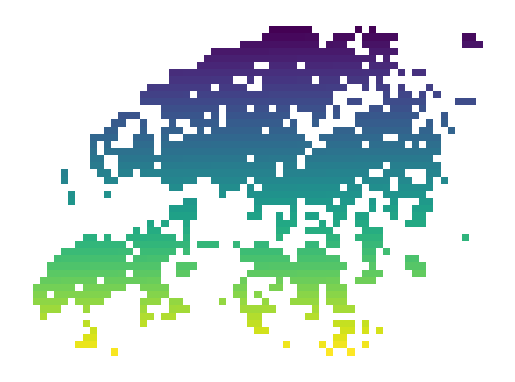

In [67]:
species_df.plot(column='gno')
plt.axis(False)
plt.show()

In [68]:
len(species_df['gno'].unique()) == len(species_df['geometry'].unique())

True

* The distribution of `gno` and the same unique number of `gno` and `geometry` indicate that these two columns share the same information regarding the location of the occurence.
    * They both can be used as *target value*. 
* Similarly, `Shape__Are` and `Shape__Len` will be removed due to duplicated information.
* Removing `date` due to redundancy.

In [69]:
species_df.drop(columns=['Shape__Are', 'Shape__Len', 'date'], inplace=True)
species_df.head(10)

scientific         family   gno  \
0           Myrrophis chinensis   Homalopsidae  1575   
1  Psammodynastes pulverulentus  Lamprophiidae  1657   
2                Troides helena   Papilionidae   879   
3            Viverricula indica     Viverridae   807   
4           Muntiacus vaginalis       Cervidae   807   
5            Viverricula indica     Viverridae   877   
6           Muntiacus vaginalis       Cervidae   807   
7            Viverricula indica     Viverridae   807   
8            Viverricula indica     Viverridae  1447   
9            Viverricula indica     Viverridae  1369   

                                            geometry  year  month  
0  POLYGON Z ((833000.000 828000.001 0.000, 83400...  2001      7  
1  POLYGON Z ((845000.000 827000.001 0.000, 84600...  2001      7  
2  POLYGON Z ((837000.000 838000.001 0.000, 83800...  2001      7  
3  POLYGON Z ((835000.000 839000.002 0.000, 83600...  2001     10  
4  POLYGON Z ((835000.000 839000.002 0.000, 83600...  2001     10  
5  POLYGON Z ((835000.000 838000.001 0.000, 83600...  2001     10  
6  POLYGON Z ((835000.000 839000.002 0.000, 83600...  2001     11  
7  POLYGON Z ((835000.000 839000.002 0.000, 83600...  2001     10  
8  POLYGON Z ((845000.000 830000.001 0.000, 84600...  2001     10  
9  POLYGON Z ((837000.000 831000.001 0.000, 83800...  2001     11

## Data Preprocessing

In [70]:
# Extract unique species names
species = sorted(species_df['scientific'].unique().tolist())

[260]
[1500, 1501, 1502, 1504, 1505, 1506, 1507, 1508, 1509, 1511, 1512, 1513, 1514, 1515, 1516, 1517, 1518, 1519, 1520, 1521, 1522, 1523, 1524, 1525, 1526, 1527, 1528, 1551, 1552, 1555, 1556, 1557, 1558, 1559, 1561, 1562, 1563, 1564, 1565, 1566, 1567, 1568, 1569, 1570, 1571, 1572, 1573, 1574, 1575, 1576, 1578, 1579, 1581, 1582, 1583, 1584, 1585, 1586, 1587, 1588, 1589, 1590, 1591, 1593, 1594, 1595, 1596, 1597, 1598, 1599]
[1617, 1622, 1623, 1625, 1626, 1628, 1629, 1630, 1631, 1632, 1633, 1634, 1635, 1636, 1637, 1638, 1639, 1640, 1641, 1642, 1643, 1644, 1645, 1646, 1648, 1649, 1650, 1651, 1652, 1653, 1654, 1655, 1656, 1657, 1658, 1659, 1662, 1663, 1664, 1668, 1669, 1687, 1693, 1694]


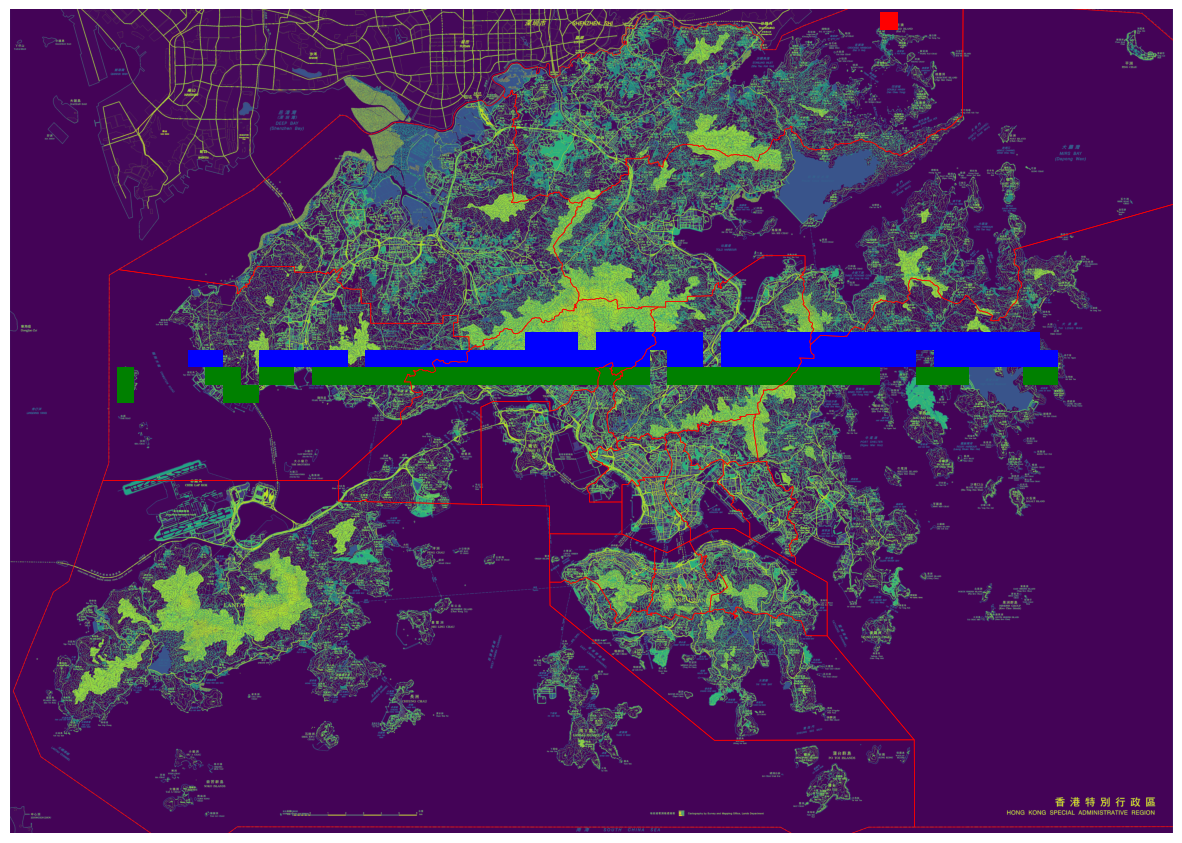

In [71]:
# Visualise samples to examine gno distribution
bound_left, bound_right, bound_top, bound_bottom = hkmap.bounds.left, hkmap.bounds.right, hkmap.bounds.top, hkmap.bounds.bottom
extent = (bound_left, bound_right, bound_bottom, bound_top)

gno_sample_2 = [gno for gno in sorted(species_df['gno'].unique().tolist()) if gno in [260]]
gno_sample_3 = [gno for gno in sorted(species_df['gno'].unique().tolist()) if gno in np.arange(1500, 1600)]
gno_sample_4 = [gno for gno in sorted(species_df['gno'].unique().tolist()) if gno in np.arange(1600, 1700)]
print(gno_sample_2)
print(gno_sample_3)
print(gno_sample_4)

fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(hkmap_array, extent=extent, origin='upper', vmin=hkmap_array.min(), vmax=hkmap_array.max())
districts.boundary.plot(ax=ax, color='red', linewidth=0.5)
species_df.loc[species_df['gno'].isin(gno_sample_2)].plot(ax=ax, color='red')
species_df.loc[species_df['gno'].isin(gno_sample_3)].plot(ax=ax, color='blue')
species_df.loc[species_df['gno'].isin(gno_sample_4)].plot(ax=ax, color='green')
ax.set_axis_off()
ax.set(xlim=(bound_left, bound_right), ylim=(bound_bottom, bound_top))
plt.show()

&emsp;The plot above shows that the `gno` values are arranged from 0 to the maximum number of pixel within the Hong Kong region. While the smallest value 0 starts at the top row and leftmost pixel of the region. The first two digits are **not** the row number. Therefore, `gno` cannot be easily converted into coordinates.

In [72]:
species_df['centroid'] = species_df['geometry'].centroid
species_df['x'] = species_df['centroid'].x
species_df['y'] = species_df['centroid'].y
species_df[['gno', 'centroid', 'x', 'y']].head()

gno                       centroid              x              y
0  1575  POINT (833500.000 827500.001)  833500.000355  827500.001444
1  1657  POINT (845500.000 826500.001)  845500.000372  826500.001455
2   879  POINT (837500.000 837500.001)  837500.000426  837500.001460
3   807  POINT (835500.000 838500.002)  835500.000413  838500.001508
4   807  POINT (835500.000 838500.002)  835500.000413  838500.001508

801500.0004114339
803500.0004179936
804500.0004394505
805500.0004328473
806500.0004328745


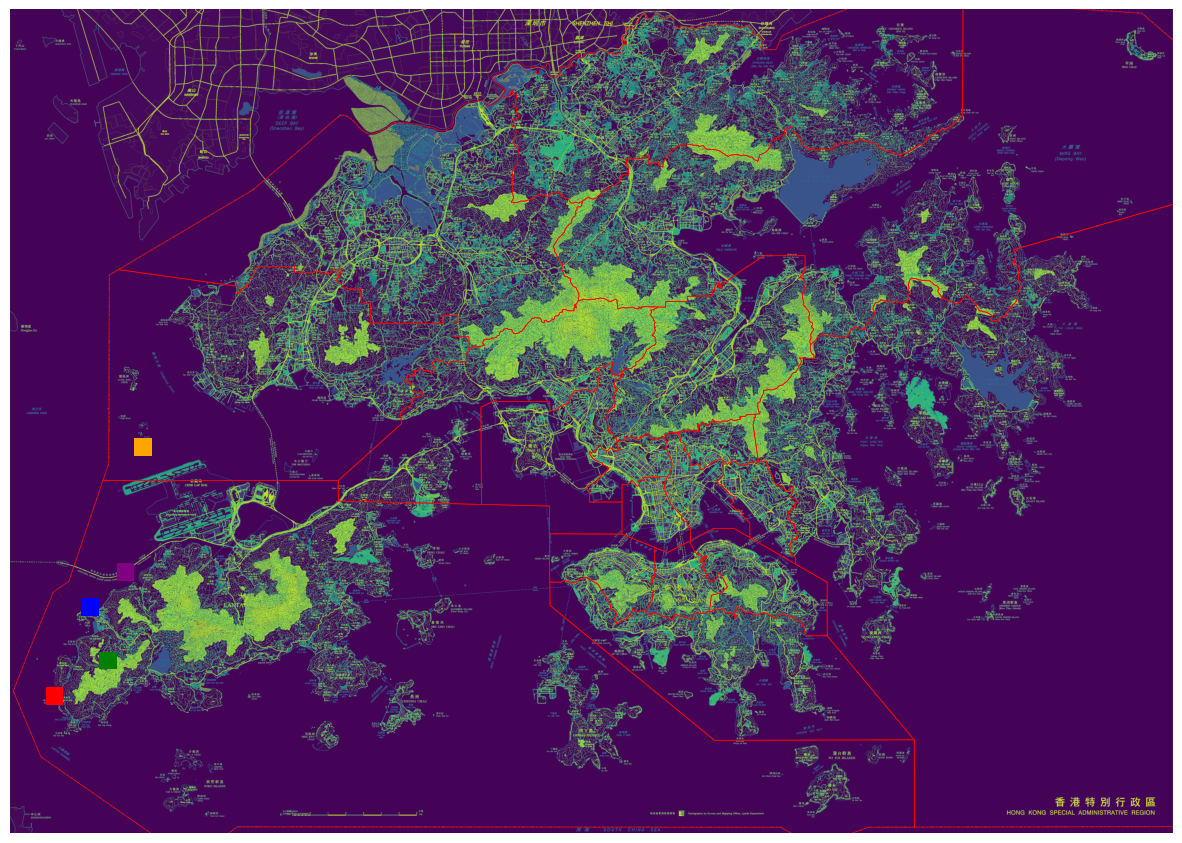

In [73]:
x_sample_1 = sorted(species_df['x'].unique().tolist())[0]
x_sample_2 = sorted(species_df['x'].unique().tolist())[9]
x_sample_3 = sorted(species_df['x'].unique().tolist())[19]
x_sample_4 = sorted(species_df['x'].unique().tolist())[29]
x_sample_5 = sorted(species_df['x'].unique().tolist())[39]
print(x_sample_1)
print(x_sample_2)
print(x_sample_3)
print(x_sample_4)
print(x_sample_5)

fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(hkmap_array, extent=extent, origin='upper', vmin=hkmap_array.min(), vmax=hkmap_array.max())
districts.boundary.plot(ax=ax, color='red', linewidth=0.5)
species_df.loc[species_df['x']==(x_sample_1)].plot(ax=ax, color='red')
species_df.loc[species_df['x']==(x_sample_2)].plot(ax=ax, color='blue')
species_df.loc[species_df['x']==(x_sample_3)].plot(ax=ax, color='green')
species_df.loc[species_df['x']==(x_sample_4)].plot(ax=ax, color='purple')
species_df.loc[species_df['x']==(x_sample_5)].plot(ax=ax, color='orange')
ax.set_axis_off()
ax.set(xlim=(bound_left, bound_right), ylim=(bound_bottom, bound_top))
plt.show()

&emsp;The `x` and `y` coordinates of the `centroids` can be used as predictive features to examine the neighbouring effect.

In [74]:
species_df.head(2)

scientific         family   gno  \
0           Myrrophis chinensis   Homalopsidae  1575   
1  Psammodynastes pulverulentus  Lamprophiidae  1657   

                                            geometry  year  month  \
0  POLYGON Z ((833000.000 828000.001 0.000, 83400...  2001      7   
1  POLYGON Z ((845000.000 827000.001 0.000, 84600...  2001      7   

                        centroid              x              y  
0  POINT (833500.000 827500.001)  833500.000355  827500.001444  
1  POINT (845500.000 826500.001)  845500.000372  826500.001455

### Grids of Hong Kong Map (20x20: 400 cells)

In [75]:
# Create bins using boundaries of Hong Kong map
x_bins = 20
y_bins = 20
x_bins = np.linspace(bound_left, bound_right, x_bins+1)
y_bins = np.linspace(bound_bottom, bound_top, y_bins+1)

species_df['x_bin'] = pd.cut(species_df['x'], bins=x_bins, labels=False)
species_df['y_bin'] = pd.cut(species_df['y'], bins=y_bins, labels=False)

species_df.head(2)

scientific         family   gno  \
0           Myrrophis chinensis   Homalopsidae  1575   
1  Psammodynastes pulverulentus  Lamprophiidae  1657   

                                            geometry  year  month  \
0  POLYGON Z ((833000.000 828000.001 0.000, 83400...  2001      7   
1  POLYGON Z ((845000.000 827000.001 0.000, 84600...  2001      7   

                        centroid              x              y  x_bin  y_bin  
0  POINT (833500.000 827500.001)  833500.000355  827500.001444     10     11  
1  POINT (845500.000 826500.001)  845500.000372  826500.001455     14     11

In [76]:
# Grid id assigned to each cell as target variable
def create_grid(x_bins=20, y_bins=20):
    grid_cells = []
    for i in range(y_bins):
        for j in range(x_bins):
            cell = {
                'y_bin': i,
                'x_bin': j,
                'id': i * x_bins + j
            }
            grid_cells.append(cell)
    return grid_cells

grid_cells = create_grid(x_bins=20, y_bins=20)

# Assign id to each occurrence record
def griding(x_bin, y_bin):
    for grid in grid_cells:
        if grid['x_bin'] == x_bin and grid['y_bin'] == y_bin:
            return grid['id']
    return None

species_df['grid_id'] = species_df.apply(lambda row: griding(row['x_bin'], row['y_bin']), axis=1)
species_df.head(5)

scientific         family   gno  \
0           Myrrophis chinensis   Homalopsidae  1575   
1  Psammodynastes pulverulentus  Lamprophiidae  1657   
2                Troides helena   Papilionidae   879   
3            Viverricula indica     Viverridae   807   
4           Muntiacus vaginalis       Cervidae   807   

                                            geometry  year  month  \
0  POLYGON Z ((833000.000 828000.001 0.000, 83400...  2001      7   
1  POLYGON Z ((845000.000 827000.001 0.000, 84600...  2001      7   
2  POLYGON Z ((837000.000 838000.001 0.000, 83800...  2001      7   
3  POLYGON Z ((835000.000 839000.002 0.000, 83600...  2001     10   
4  POLYGON Z ((835000.000 839000.002 0.000, 83600...  2001     10   

                        centroid              x              y  x_bin  y_bin  \
0  POINT (833500.000 827500.001)  833500.000355  827500.001444     10     11   
1  POINT (845500.000 826500.001)  845500.000372  826500.001455     14     11   
2  POINT (837500.000 837500.001)  837500.000426  837500.001460     11     15   
3  POINT (835500.000 838500.002)  835500.000413  838500.001508     11     16   
4  POINT (835500.000 838500.002)  835500.000413  838500.001508     11     16   

   grid_id  
0      230  
1      234  
2      311  
3      331  
4      331

In [77]:
grid_cells

[{'y_bin': 0, 'x_bin': 0, 'id': 0},
 {'y_bin': 0, 'x_bin': 1, 'id': 1},
 {'y_bin': 0, 'x_bin': 2, 'id': 2},
 {'y_bin': 0, 'x_bin': 3, 'id': 3},
 {'y_bin': 0, 'x_bin': 4, 'id': 4},
 {'y_bin': 0, 'x_bin': 5, 'id': 5},
 {'y_bin': 0, 'x_bin': 6, 'id': 6},
 {'y_bin': 0, 'x_bin': 7, 'id': 7},
 {'y_bin': 0, 'x_bin': 8, 'id': 8},
 {'y_bin': 0, 'x_bin': 9, 'id': 9},
 {'y_bin': 0, 'x_bin': 10, 'id': 10},
 {'y_bin': 0, 'x_bin': 11, 'id': 11},
 {'y_bin': 0, 'x_bin': 12, 'id': 12},
 {'y_bin': 0, 'x_bin': 13, 'id': 13},
 {'y_bin': 0, 'x_bin': 14, 'id': 14},
 {'y_bin': 0, 'x_bin': 15, 'id': 15},
 {'y_bin': 0, 'x_bin': 16, 'id': 16},
 {'y_bin': 0, 'x_bin': 17, 'id': 17},
 {'y_bin': 0, 'x_bin': 18, 'id': 18},
 {'y_bin': 0, 'x_bin': 19, 'id': 19},
 {'y_bin': 1, 'x_bin': 0, 'id': 20},
 {'y_bin': 1, 'x_bin': 1, 'id': 21},
 {'y_bin': 1, 'x_bin': 2, 'id': 22},
 {'y_bin': 1, 'x_bin': 3, 'id': 23},
 {'y_bin': 1, 'x_bin': 4, 'id': 24},
 {'y_bin': 1, 'x_bin': 5, 'id': 25},
 {'y_bin': 1, 'x_bin': 6, 'id': 26},
 

In [78]:
# Boxes for each grid cell
grid_cells_boxes = []
for cell in grid_cells:
    x_min = x_bins[cell['x_bin']]
    x_max = x_bins[cell['x_bin'] + 1]
    y_min = y_bins[cell['y_bin']]
    y_max = y_bins[cell['y_bin'] + 1]
    box = shapely.geometry.box(x_min, y_min, x_max, y_max)
    grid_cells_boxes.append(box)

grid_cells_boxes

[<POLYGON ((802272 800790, 802272 803108, 799000 803108, 799000 800790, 80227...>,
 <POLYGON ((805544 800790, 805544 803108, 802272 803108, 802272 800790, 80554...>,
 <POLYGON ((808816 800790, 808816 803108, 805544 803108, 805544 800790, 80881...>,
 <POLYGON ((812088 800790, 812088 803108, 808816 803108, 808816 800790, 81208...>,
 <POLYGON ((815360 800790, 815360 803108, 812088 803108, 812088 800790, 81536...>,
 <POLYGON ((818632 800790, 818632 803108, 815360 803108, 815360 800790, 81863...>,
 <POLYGON ((821904 800790, 821904 803108, 818632 803108, 818632 800790, 82190...>,
 <POLYGON ((825176 800790, 825176 803108, 821904 803108, 821904 800790, 82517...>,
 <POLYGON ((828448 800790, 828448 803108, 825176 803108, 825176 800790, 82844...>,
 <POLYGON ((831720 800790, 831720 803108, 828448 803108, 828448 800790, 83172...>,
 <POLYGON ((834992 800790, 834992 803108, 831720 803108, 831720 800790, 83499...>,
 <POLYGON ((838264 800790, 838264 803108, 834992 803108, 834992 800790, 83826...>,
 <PO

In [79]:
def species_layer(species_df):
    species_layers = {}
    for s in species:
        layer = np.zeros((len(np.arange(2001, 2025)), 20, 20), dtype=int)
        species_data = species_df[species_df['scientific'] == s]
        for _, row in species_data.iterrows():
            if pd.notnull(row['x_bin']) and pd.notnull(row['y_bin']):
                layer[row['year'] - 2001, int(row['y_bin']), int(row['x_bin'])] += 1
        species_layers[s] = layer
    return species_layers

species_layers = species_layer(species_df)

## Deep Neural Network

In [152]:
import torch
import torch.nn as nn

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # First fully connected layer: from 400 (20x20) to 512 neurons
        self.fc1 = nn.Linear(20 * 20, 512)
        # Second fully connected layer: from 512 to (20x20: 400) neurons
        self.fc2 = nn.Linear(512, 400)

    def forward(self, x):
        # Flatten the image input
        x = x.view(-1, 20 * 20)
        # Apply the first FC layer and sigmoid activation
        x = self.fc1(x)
        x = torch.sigmoid(x)
        # Apply the second FC layer (output layer)
        x = self.fc2(x)
        
        return x

In [153]:
def train_model(species):
    # Initialize the network and print its architecture
    model = Net()
    print(model)

    # Specify loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

    # Define device
    device = torch.device('mpu' if torch.cuda.is_available() else 'cpu')

    # Specify species for training and inference
    species_layer = species_layers[species]
    X = torch.tensor(species_layer[:23, :, :]).reshape(23, -1).to(torch.float32)
    y = torch.tensor(species_layer[1:, :, :]).reshape(23, -1).to(torch.float32)
    print("X", X.shape)
    print("y", y.shape)

    # Number of epochs for training
    n_epochs = 5  # For a faster demo; consider using between 20-50 epochs for real training
    model.train()  # Set the model to training mode
    for epoch in range(n_epochs):
        train_loss = 0.0
        
        # Train the model on each batch
        data, target = X.to(device), y.to(device)  # Move data to GPU if available
        optimizer.zero_grad()         # Clear gradients
        output = model(data)            # Forward pass
        loss = criterion(output, target)  # Calculate loss
        loss.backward()                 # Backward pass
        optimizer.step()                # Update parameters
        train_loss += loss.item()# * data.size(0)  # Accumulate loss
        
        # Calculate average loss over the epoch
        # train_loss = train_loss / len(train_loader.dataset)
        print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch+1, train_loss))

    return model

In [154]:
# NOT USED YET
# Visualise predicted grid cells with intensity
def inference_model(species, model):
    # model.eval()
    # with torch.no_grad():
    #     for i in range(23):
    #         test_data = torch.tensor(abisara_echerius_layer[i, :, :]).unsqueeze(0).to(torch.float32).to(device)
    #         test_output = model(test_data)
    #         predicted_grid = test_output.cpu().numpy().reshape(20, 20)

    # Inference on the last layer (2024)
    species_layer = species_layers[species]
    # Define device
    device = torch.device('mpu' if torch.cuda.is_available() else 'cpu')
    model.eval()
    with torch.no_grad():
        test_data = torch.tensor(species_layer[-1, :, :]).unsqueeze(0).to(torch.float32).to(device)
        test_output = model(test_data)
        predicted_grid = test_output.cpu().numpy()
        predicted_grid = predicted_grid.reshape(20, 20)
        # predicted_grid = np.round(predicted_grid)

    # Create a GeoDataFrame - each row contains grid id, geometry (box), and prediction (0 for now)
    grid_cells_boxes_species = []
    for i in range(400):
        grid_cells_boxes_species.append({'id': i,
                                         'geometry': grid_cells_boxes[i],
                                         'prediction': 0})

    # Add prediction count
    for i in range(20): # y
        for j in range(20): # x
            grid_cells_boxes_species[i * 20 + j]['prediction'] += predicted_grid[predicted_grid.shape[0]-1-i, j]
    for i in range(400):
        if grid_cells_boxes_species[i]['prediction'] < 0:
            grid_cells_boxes_species[i]['prediction'] = 0
            # if predicted_grid[predicted_grid.shape[0]-1-i, j] >= 1:
            #     grid_cells_boxes_species[i * 20 + j]['prediction'] += 1
            #     if grid_cells_boxes_species[i * 20 + j]['prediction'] > 1:
            #         print("HORRAY!")

    # Turn into GeoDataFrame
    grid_cells_gdf = gpd.GeoDataFrame(grid_cells_boxes_species, crs=hkmap.crs, geometry='geometry')

    # Visualise the centroids on the map
    fig, ax = plt.subplots(figsize=(15, 15))
    ax.imshow(hkmap_array, extent=extent, origin='upper', vmin=hkmap_array.min(), vmax=hkmap_array.max())
    districts.boundary.plot(ax=ax, color='red', linewidth=0.5)
    grid_cells_gdf.plot(ax=ax, linewidth=.1, column='prediction', cmap='YlOrRd', alpha=.3, legend=True) # facecolor='yellow', edgecolor='blue',
    ax.set_axis_off()
    ax.set(xlim=(bound_left, bound_right), ylim=(bound_bottom, bound_top))
    plt.title(f"{species} Predicted Locations in 2025", fontsize=20)
    plt.show()

    return grid_cells_gdf

In [155]:
# def inference_model(species, model):
#     # model.eval()
#     # with torch.no_grad():
#     #     for i in range(23):
#     #         test_data = torch.tensor(abisara_echerius_layer[i, :, :]).unsqueeze(0).to(torch.float32).to(device)
#     #         test_output = model(test_data)
#     #         predicted_grid = test_output.cpu().numpy().reshape(20, 20)

#     # Inference on the last layer (2024)
#     species_layer = species_layers[species]
#     # Define device
#     device = torch.device('mpu' if torch.cuda.is_available() else 'cpu')
#     model.eval()
#     with torch.no_grad():
#         test_data = torch.tensor(species_layer[-1, :, :]).unsqueeze(0).to(torch.float32).to(device)
#         test_output = model(test_data)
#         predicted_grid = test_output.cpu().numpy().reshape(20, 20)
#         print("predicted_grid", predicted_grid)
#         # predicted_grid = np.round(predicted_grid)

#     # Get the grid_id of each cell with value >= 1
#     grid_ids = []
#     for i in range(20):
#         for j in range(20):
#             if predicted_grid[i, j] >= .5: #1:
#                 grid_ids.append((i, j))

#     # Convert grid_ids to centroids
#     centroids = []
#     boxes = []
#     for grid in grid_ids:
#         x_bin, y_bin = grid
#         x_center = (x_bins[x_bin] + x_bins[x_bin + 1]) / 2
#         y_center = (y_bins[y_bin] + y_bins[y_bin + 1]) / 2
#         centroids.append((x_center, y_center))
#         boxes.append(shapely.box(x_bins[x_bin], y_bins[y_bin], x_bins[x_bin + 1], y_bins[y_bin + 1]))

#     # Visualise the centroids on the map
#     fig, ax = plt.subplots(figsize=(15, 15))
#     ax.imshow(hkmap_array, extent=extent, origin='upper', vmin=hkmap_array.min(), vmax=hkmap_array.max())
#     districts.boundary.plot(ax=ax, color='red', linewidth=0.5)
#     for box in boxes:
#         gpd.GeoSeries(box).plot(ax=ax, facecolor='none', edgecolor='yellow', linewidth=1, alpha=1)
#     # for centroid in centroids:
#     #     ax.plot(centroid[0], centroid[1], 'ro')  # Plot centroids as red dots
#     ax.set_axis_off()
#     ax.set(xlim=(bound_left, bound_right), ylim=(bound_bottom, bound_top))
#     plt.title(f"{species} Predicted Locations in 2025", fontsize=20)
#     plt.show()

#     return boxes

In [156]:
species

['Abisara echerius',
 'Abraximorpha davidii',
 'Abroscopus albogularis',
 'Abscondita terminalis',
 'Acanthastrea echinata',
 'Acanthastrea hemprichii',
 'Acanthastrea minuta',
 'Acanthastrea subechinata',
 'Acanthopagrus chinshira',
 'Acanthopagrus latus',
 'Acanthopagrus pacificus',
 'Acanthopagrus schlegelii',
 'Accipiter gentilis',
 'Accipiter gularis',
 'Accipiter nisus',
 'Accipiter soloensis',
 'Accipiter trivirgatus',
 'Accipiter virgatus',
 'Acentrogobius caninus',
 'Acentrogobius pflaumii',
 'Acentrogobius viridipunctatus',
 'Achalinus rufescens',
 'Aciagrion approximans',
 'Acisoma panorpoides',
 'Acraea issoria',
 'Acridotheres cristatellus',
 'Acridotheres tristis',
 'Acrocephalus bistrigiceps',
 'Acrocephalus dumetorum',
 'Acrocephalus orientalis',
 'Acrocephalus tangorum',
 'Acropora digitifera',
 'Acropora glauca',
 'Acropora pruinosa',
 'Acropora solitaryensis',
 'Acropora tumida',
 'Actinodura cyanouroptera',
 'Actitis hypoleucos',
 'Acytolepis puspa',
 'Aegithalos co

Occurrences: 63
Net(
  (fc1): Linear(in_features=400, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=400, bias=True)
)
X torch.Size([23, 400])
y torch.Size([23, 400])
Epoch: 1 	Training Loss: 16.503910
Epoch: 2 	Training Loss: 13.932435
Epoch: 3 	Training Loss: 11.491146
Epoch: 4 	Training Loss: 9.428009
Epoch: 5 	Training Loss: 8.065130


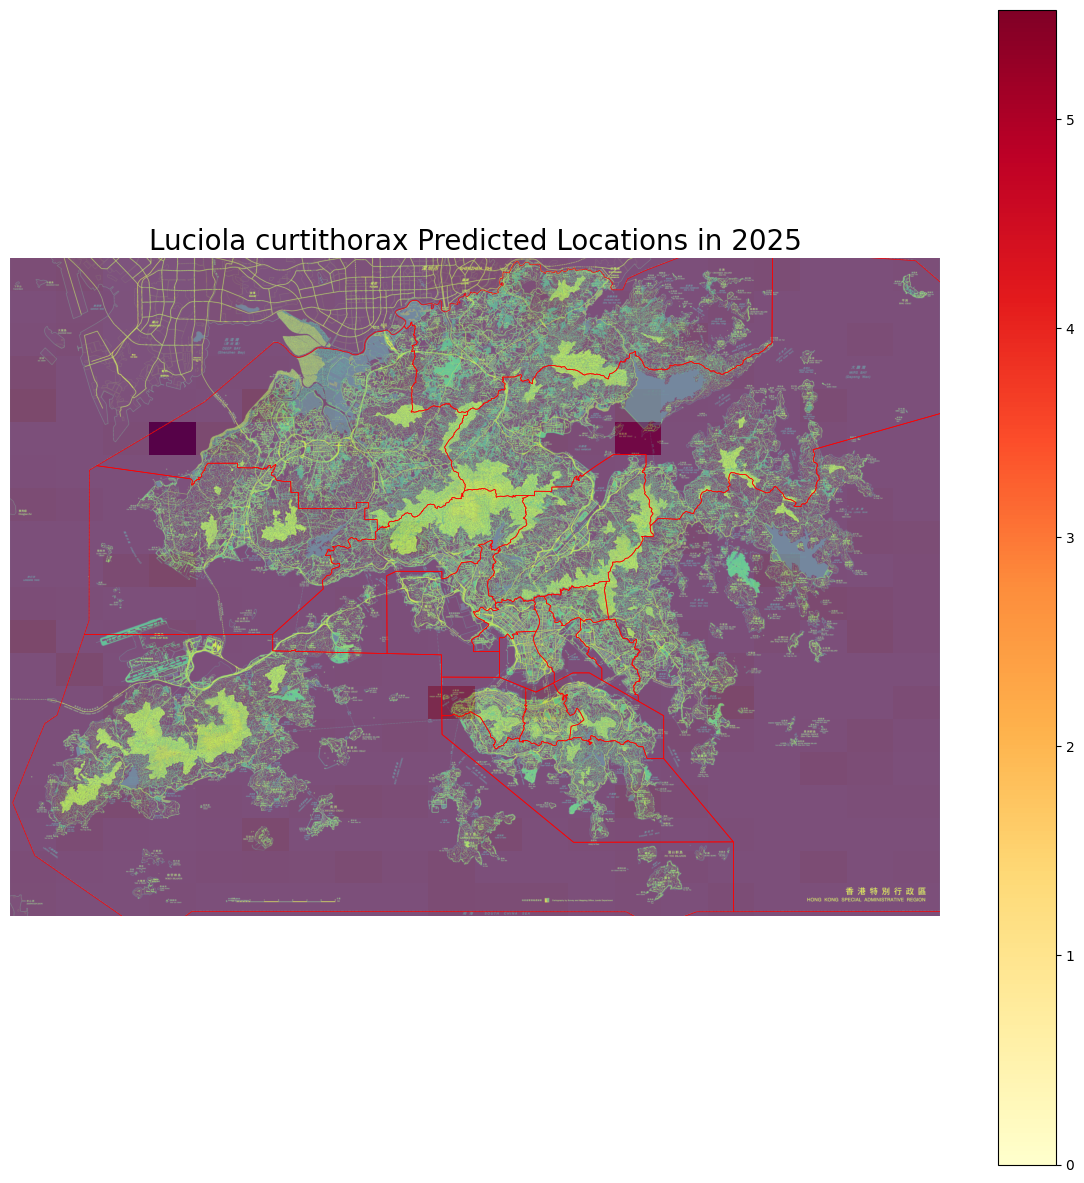

In [157]:
a_species = 'Luciola curtithorax' # 'Agropsar philippensis'
print("Occurrences:", species_layers[a_species].sum())

trained_model = train_model(a_species)
grid_cells_gdf = inference_model(a_species, trained_model)

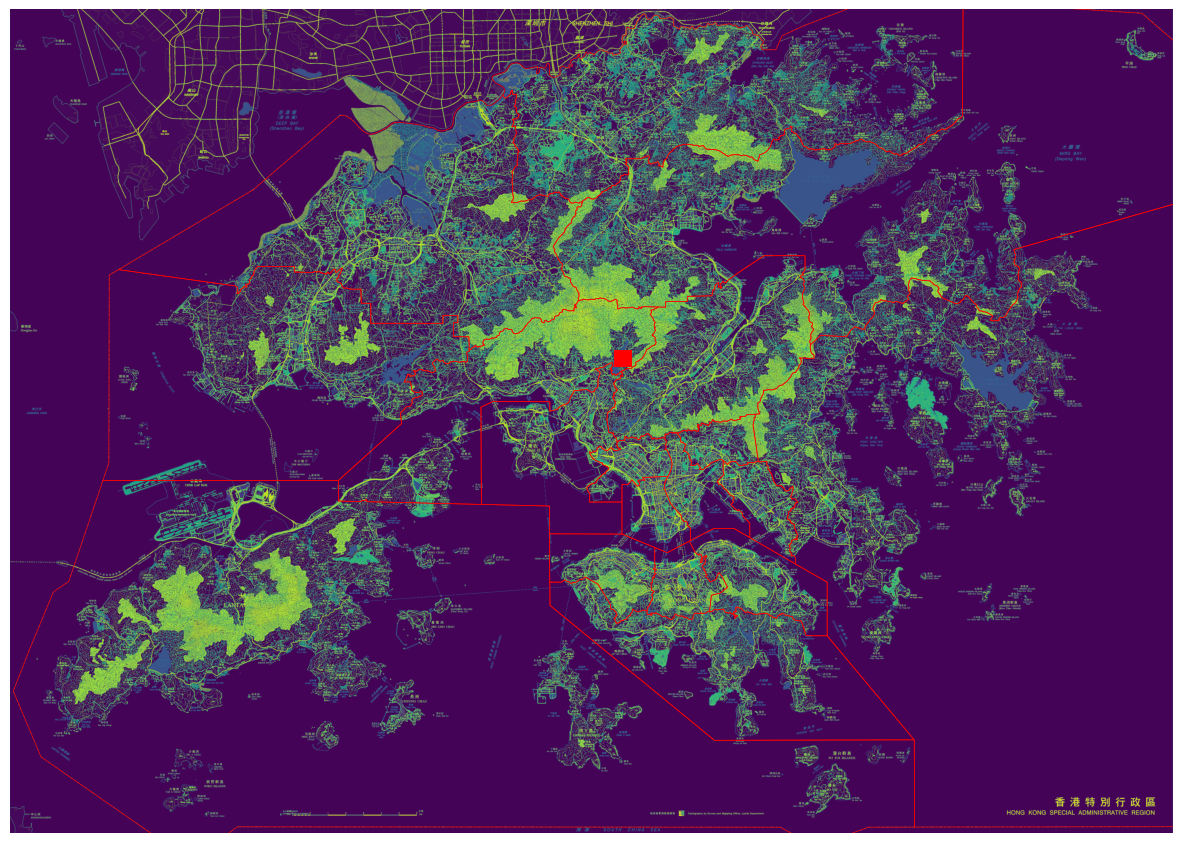

In [ ]:
# VISUALISATION SAMPLE

bound_left, bound_right, bound_top, bound_bottom = hkmap.bounds.left, hkmap.bounds.right, hkmap.bounds.top, hkmap.bounds.bottom
extent = (bound_left, bound_right, bound_bottom, bound_top)

fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(hkmap_array, extent=extent, origin='upper', vmin=hkmap_array.min(), vmax=hkmap_array.max())
districts.boundary.plot(ax=ax, color='red', linewidth=0.5)
species_df.iloc[:1].plot(ax=ax, color='red')
ax.set_axis_off()
ax.set(xlim=(bound_left, bound_right), ylim=(bound_bottom, bound_top))
plt.show()